In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
sys.path.append("/Users/binxuwang/Github/DiffusionLearningCurve/")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *
from core.img_patch_stats_analysis_lib import *
import os
import pickle as pkl
from circuit_toolkit.plot_utils import saveallforms
saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"

def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

### GMM

In [3]:
from core.gaussian_mixture_lib import GaussianMixture_torch

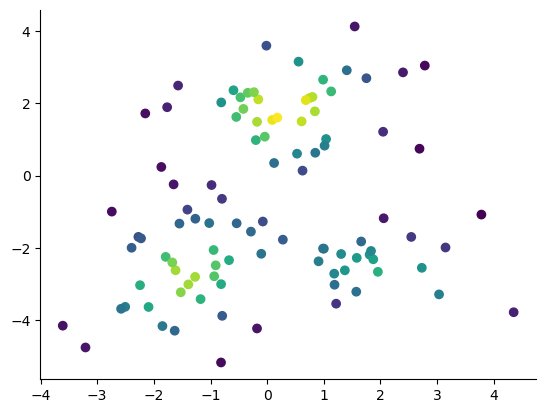

In [4]:
mus = [torch.tensor([-1.5, -2.8]), torch.tensor([2.1, -2.7]), torch.tensor([0.3, 1.9])]
covs = [torch.tensor([[0.8, 0.3], [0.3, 1.2]]), 
        torch.tensor([[1.5, -0.4], [-0.4, 0.6]]), 
        torch.tensor([[0.9, 0.1], [0.1, 1.1]])]
weights = [1.2, 0.8, 1.5]
gmm = GaussianMixture_torch(mus, covs, weights)
# x = torch.randn(1000, 2)
# y = gmm.pdf(x)
x, _, _ = gmm.sample(100)
density = gmm.pdf(x)
plt.scatter(x[:, 0], x[:, 1], c=density, cmap="viridis")
plt.show()

In [5]:
def delta_GMM_score(Xt, train_Xmat, sigma, return_weights=False):
    # get squared distance matrix
    sqdist = torch.cdist(Xt, train_Xmat, p=2) ** 2
    weights = F.softmax(-sqdist / (2 * sigma**2), dim=1)
    score = (torch.matmul(weights, train_Xmat) - Xt) / sigma**2
    if return_weights:
        return score, weights
    else:
        return score


def delta_GMM_denoiser(Xt, train_Xmat, sigma):
    # get squared distance matrix
    sqdist = torch.cdist(Xt.flatten(1), train_Xmat.flatten(1), p=2) ** 2
    weights = F.softmax(-sqdist / (2 * sigma**2), dim=1)
    denoised = torch.matmul(weights, train_Xmat)
    return denoised

In [6]:
class EDMDeltaGMMScoreLoss:
    def __init__(self, train_Xmat, P_mean=-1.2, P_std=1.2, sigma_data=0.5):
        self.train_Xmat = train_Xmat
        self.P_mean = P_mean
        self.P_std = P_std
        self.sigma_data = sigma_data

    def __call__(self, net, X, labels=None, ):
        rnd_normal = torch.randn([X.shape[0],] + [1, ] * (X.ndim - 1), device=X.device)
        # unsqueeze to match the ndim of X
        sigma = (rnd_normal * self.P_std + self.P_mean).exp()
        weight = (sigma ** 2 + self.sigma_data ** 2) / (sigma * self.sigma_data) ** 2
        # maybe augment
        n = torch.randn_like(X) * sigma
        D_yn = net(X + n, sigma, cond=labels, )
        D_gmm = delta_GMM_denoiser(X, self.train_Xmat, sigma)
        # loss = weight * ((D_yn - X) ** 2)
        loss = weight * ((D_yn - D_gmm) ** 2)
        return loss

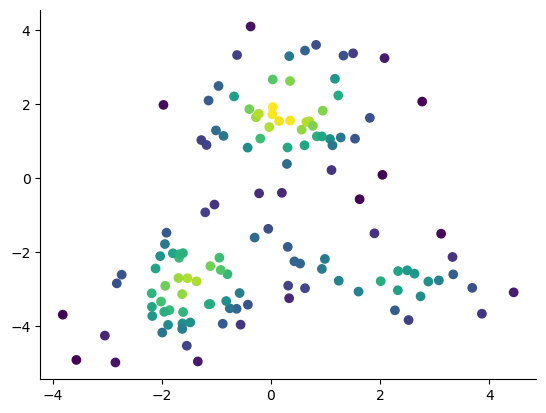

In [7]:
mus = [torch.tensor([-1.5, -2.8]), torch.tensor([2.1, -2.7]), torch.tensor([0.3, 1.9])]
covs = [torch.tensor([[0.8, 0.3], [0.3, 1.2]]), 
        torch.tensor([[1.5, -0.4], [-0.4, 0.6]]), 
        torch.tensor([[0.9, 0.1], [0.1, 1.1]])]
weights = [1.2, 0.8, 1.5]
gmm = GaussianMixture_torch(mus, covs, weights)
torch.manual_seed(42)
pnts, _, _ = gmm.sample(128)
density = gmm.pdf(pnts)
plt.scatter(pnts[:, 0], pnts[:, 1], c=density, cmap="viridis")
plt.show()

tensor(2.1833)

MNIST dataset 128 samples, 2 features


  0%|          | 0/10000 [00:00<?, ?it/s]

step 0 loss 5.920


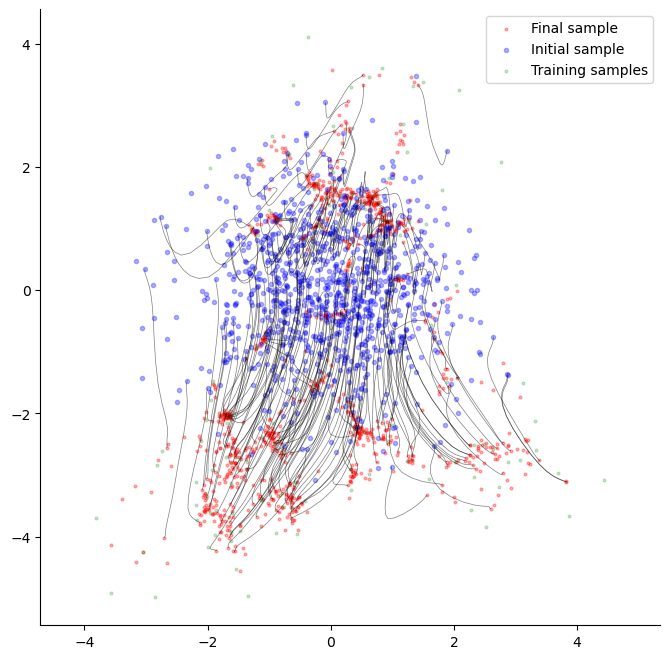

In [36]:
record_step_list = []
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model):
    loss_store[epoch] = loss
    noise_init = torch.randn(5000, ndim).to(device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), # x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

device = get_device()
# pnts = mnist_Xtsr.view(mnist_Xtsr.shape[0], -1).to(device)
# pnts = (pnts - 0.5) / 0.5
ndim = pnts.shape[1]
cov_empirical = torch.cov(pnts.T, correction=1)
print(f"MNIST dataset {pnts.shape[0]} samples, {ndim} features")
model = UNetBlockStyleMLP_backbone(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd = EDMPrecondWrapper(model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
# edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
edm_delta_gmm_loss_fn = EDMDeltaGMMScoreLoss(train_Xmat=pnts.to(device), P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(pnts, model_precd, edm_delta_gmm_loss_fn, 
                                    lr=0.0001, nepochs=10000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

noise_init = torch.randn(1000, ndim).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8, 8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=4, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=9, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=4, marker='o', alpha=0.2, label="Training samples")
plt.axis("equal")
plt.legend()
plt.show() 

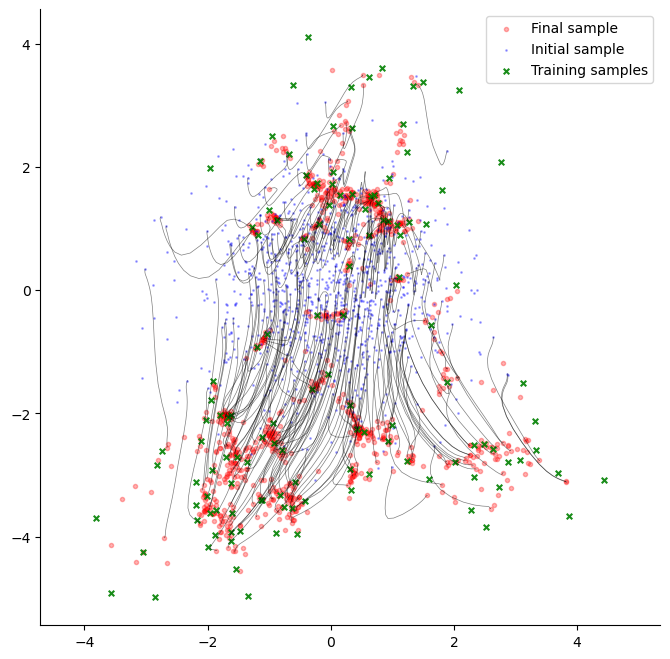

In [40]:

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8, 8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=9, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=1, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=16, marker='x', alpha=0.9, label="Training samples")
plt.axis("equal")
plt.legend()
plt.show() 

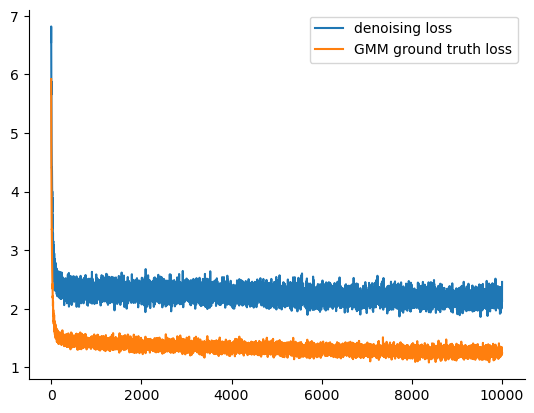

In [46]:
plt.plot(loss_traj_dsm, label="denoising loss")
plt.plot(loss_traj, label="GMM ground truth loss")
plt.legend()
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

step 0 loss 6.551


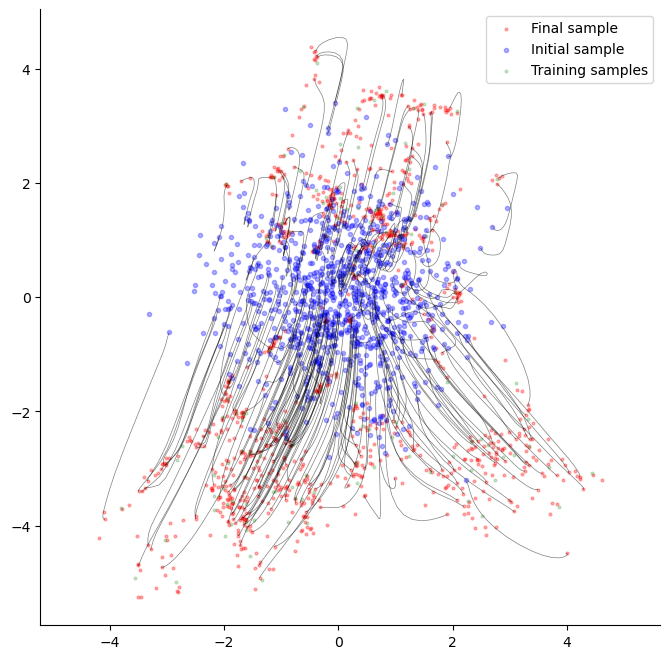

In [42]:

model_dsm = UNetBlockStyleMLP_backbone(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_dsm = EDMPrecondWrapper(model_dsm, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
# edm_delta_gmm_loss_fn = EDMDeltaGMMScoreLoss(train_Xmat=pnts.to(device), P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd_dsm, loss_traj_dsm = train_score_model_custom_loss(pnts, model_precd_dsm, edm_loss_fn, 
                                    lr=0.0001, nepochs=10000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

noise_init = torch.randn(1000, ndim).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd_dsm, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8, 8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=4, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=9, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=4, marker='o', alpha=0.2, label="Training samples")
plt.axis("equal")
plt.legend()
plt.show() 

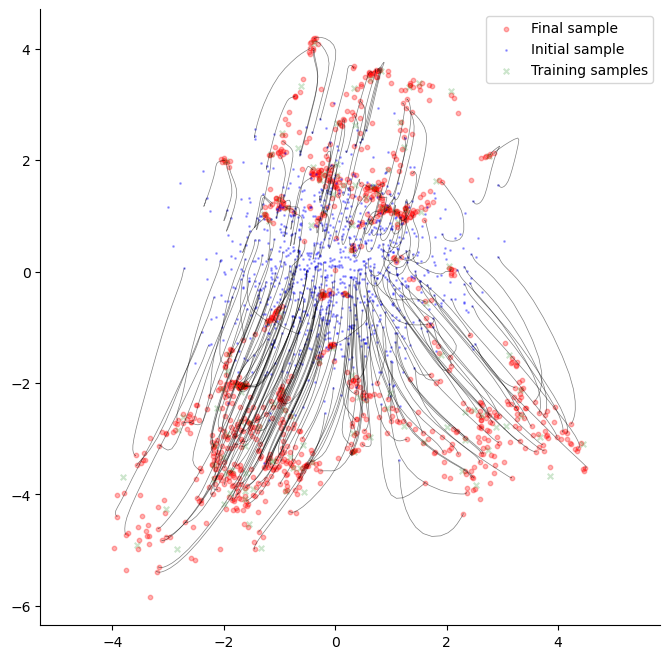

In [44]:
noise_init = torch.randn(1000, ndim, generator=torch.Generator(device=device).manual_seed(42), device=device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd_dsm, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8, 8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=10, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=1, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=16, marker='x', alpha=0.2, label="Training samples")
plt.axis("equal")
plt.legend()
plt.show() 

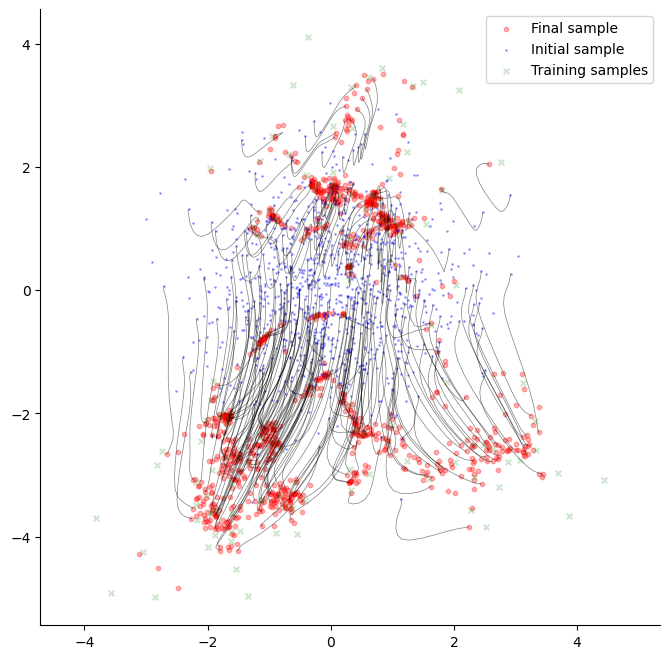

In [45]:
noise_init = torch.randn(1000, ndim, generator=torch.Generator(device=device).manual_seed(42), device=device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8, 8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=10, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=1, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=16, marker='x', alpha=0.2, label="Training samples")
plt.axis("equal")
plt.legend()
plt.show() 

### Full set up

In [ ]:
mus = [torch.tensor([-1.5, -2.8]), torch.tensor([2.1, -2.7]), torch.tensor([0.3, 1.9])]
covs = [torch.tensor([[0.8, 0.3], [0.3, 1.2]]), 
        torch.tensor([[1.5, -0.4], [-0.4, 0.6]]), 
        torch.tensor([[0.9, 0.1], [0.1, 1.1]])]
weights = [1.2, 0.8, 1.5]
gmm = GaussianMixture_torch(mus, covs, weights)
torch.manual_seed(42)
pnts, _, _ = gmm.sample(128)
density = gmm.pdf(pnts)
plt.scatter(pnts[:, 0], pnts[:, 1], c=density, cmap="viridis")
plt.show()

In [48]:
savedir = join(saveroot, "DSM_vs_Delta_ESM_loss_cmp_GMM_data")
os.makedirs(savedir, exist_ok=True)

In [56]:
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model, manual_seed=0):
    loss_store[epoch] = loss
    noise_init = torch.randn(10000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

record_step_list = [500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000]
device = get_device()
ndim = pnts.shape[1]
cov_empirical = torch.cov(pnts.T, correction=1)
print(f"MNIST dataset {pnts.shape[0]} samples, {ndim} features")
model_esm = UNetBlockStyleMLP_backbone(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_esm = EDMPrecondWrapper(model_esm, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
# edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
edm_delta_gmm_loss_fn = EDMDeltaGMMScoreLoss(train_Xmat=pnts.to(device), P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd_esm, loss_traj_esm = train_score_model_custom_loss(pnts, model_precd_esm, edm_delta_gmm_loss_fn, 
                                    lr=0.0001, nepochs=50000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

torch.save({"pnts": pnts, "mus": mus, "covs": covs, "weights": weights}, join(savedir, "training_data.pth"))
torch.save(loss_traj_esm, join(savedir, "loss_traj_esm.pth"))
torch.save(sample_store, join(savedir, "sample_store_esm.pth"))
torch.save(model_precd_esm, join(savedir, "model_precd_esm.pth"))

sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model, manual_seed=0):
    loss_store[epoch] = loss
    noise_init = torch.randn(10000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()
    
model_dsm = UNetBlockStyleMLP_backbone(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_dsm = EDMPrecondWrapper(model_dsm, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd_dsm, loss_traj_dsm = train_score_model_custom_loss(pnts, model_precd_dsm, edm_loss_fn, 
                                    lr=0.0001, nepochs=50000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

torch.save(loss_traj_dsm, join(savedir, "loss_traj_dsm.pth"))
torch.save(sample_store, join(savedir, "sample_store_dsm.pth"))
torch.save(model_precd_dsm, join(savedir, "model_precd_dsm.pth"))


# noise_init = torch.randn(1000, ndim).to(device)
# x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
#                 num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

# scaling = 1 / (t_steps ** 2 + 1).sqrt()
# scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
# plt.figure(figsize=[8, 8])
# plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
#         scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
# plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=4, marker='o', alpha=0.3, label="Final sample")
# plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=9, marker='o', alpha=0.3, label="Initial sample")
# plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=4, marker='o', alpha=0.2, label="Training samples")
# plt.axis("equal")
# plt.legend()
# plt.show() 

MNIST dataset 128 samples, 2 features


  0%|          | 0/50000 [00:00<?, ?it/s]

step 0 loss 5.487


  0%|          | 0/50000 [00:00<?, ?it/s]

step 0 loss 13.836


In [57]:
!du -sh {savedir}/*

444K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/DSM_vs_Delta_ESM_loss_cmp_GMM_data/loss_traj_dsm.pth
444K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/DSM_vs_Delta_ESM_loss_cmp_GMM_data/loss_traj_esm.pth
748K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/DSM_vs_Delta_ESM_loss_cmp_GMM_data/model_precd_dsm.pth
748K	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/DSM_vs_Delta_ESM_loss_cmp_GMM_data/model_precd_esm.pth
90M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/DSM_vs_Delta_ESM_loss_cmp_GMM_data/sample_store_dsm.pth
90M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/DSM_vs_Delta_ESM_loss_cmp_GMM_data/sample_store_esm.pth
4.0K	/n/holylfs06/LABS/kempner_f

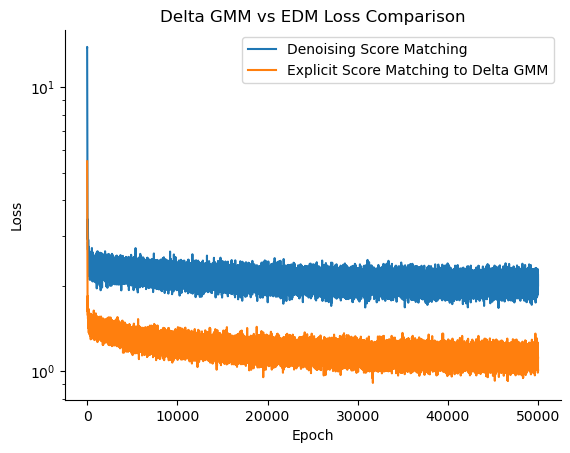

In [58]:
plt.plot(loss_traj_dsm, label="Denoising Score Matching")
plt.plot(loss_traj_esm, label="Explicit Score Matching to Delta GMM")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Delta GMM vs EDM Loss Comparison")
plt.legend()
plt.show()

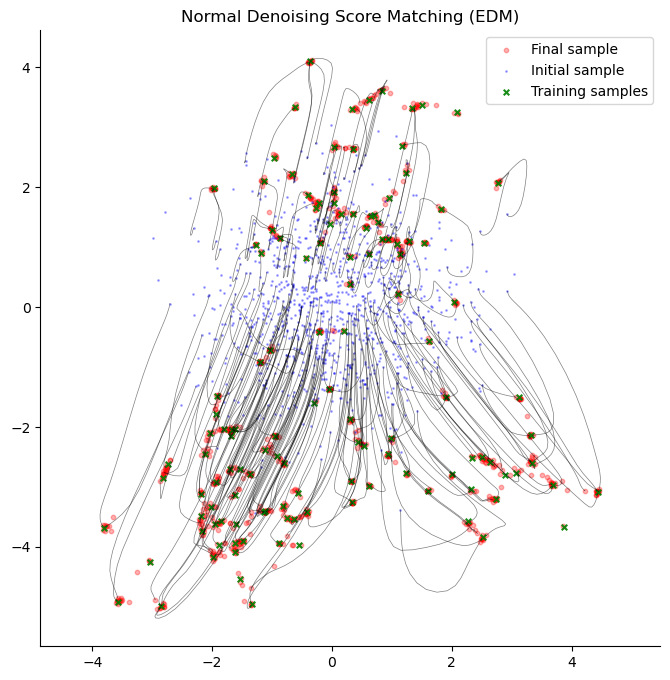

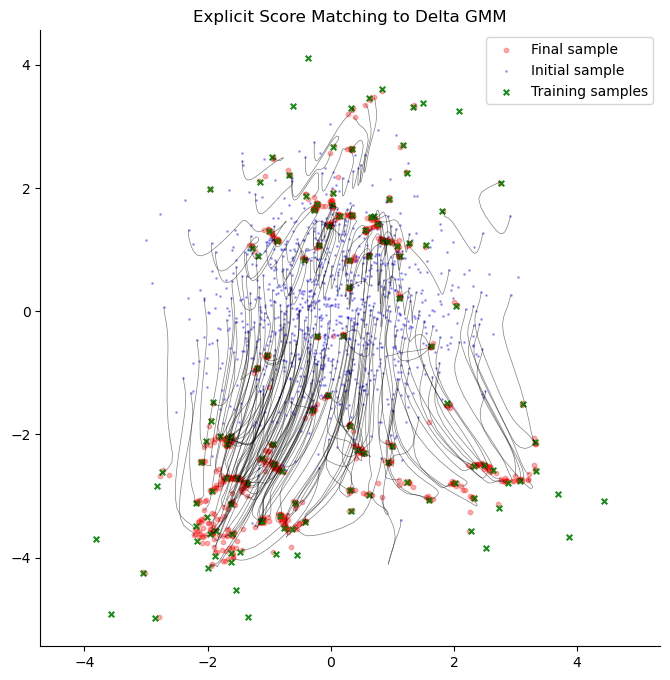

In [59]:
noise_init = torch.randn(1000, ndim, generator=torch.Generator(device=device).manual_seed(42), device=device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd_dsm, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8, 8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=10, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=1, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=16, marker='x', alpha=0.9, label="Training samples")
plt.title("Normal Denoising Score Matching (EDM)")
plt.axis("equal")
plt.legend()
plt.show() 


noise_init = torch.randn(1000, ndim, generator=torch.Generator(device=device).manual_seed(42), device=device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd_esm, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8, 8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=10, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=1, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=16, marker='x', alpha=0.9, label="Training samples")
plt.axis("equal")
plt.title("Explicit Score Matching to Delta GMM")
plt.legend()
plt.show() 

### Training traj comparison

In [60]:
sample_store_esm = torch.load(join(savedir, "sample_store_esm.pth"))
sample_store_dsm = torch.load(join(savedir, "sample_store_dsm.pth"))

# sample_store_esm_x_out = sample_store_esm[0]
# sample_store_esm_x_traj = sample_store_esm[1]
# sample_store_esm_x0hat_traj = sample_store_esm[2]
# sample_store_esm_t_steps = sample_store_esm[3]

# sample_store_dsm_x_out = sample_store_dsm[0]
# sample_store_dsm_x_traj = sample_store_dsm[1]
# sample_store_dsm_x0hat_traj = sample_store_dsm[2]
# sample_store_dsm_t_steps = sample_store_dsm[3]

/tmp/ipykernel_3659230/1705855115.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_store_esm = torch.load(join(savedir, "sample_store_esm.pth"))
/tmp/ipykernel_365

In [62]:
train_step = 500
samples_esm, x_traj_esm, x0hat_traj_esm, t_steps_esm = sample_store_esm[train_step]
samples_dsm, x_traj_dsm, x0hat_traj_dsm, t_steps_dsm = sample_store_dsm[train_step]

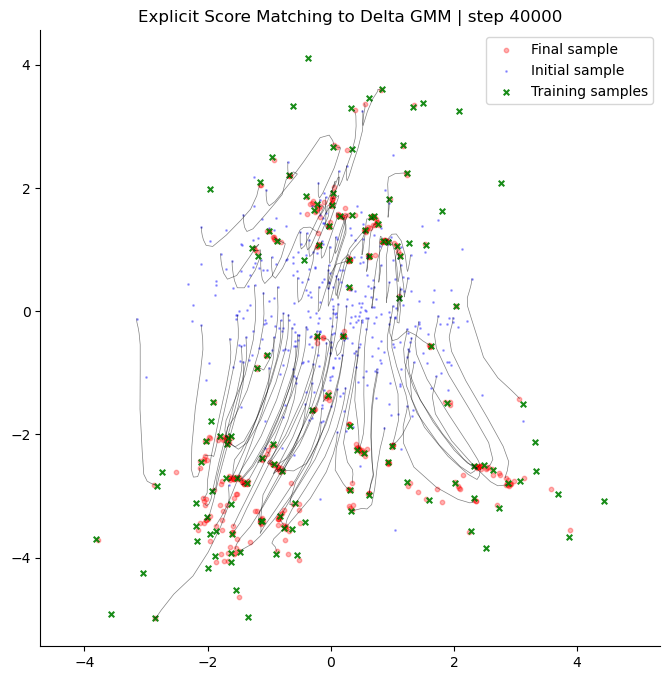

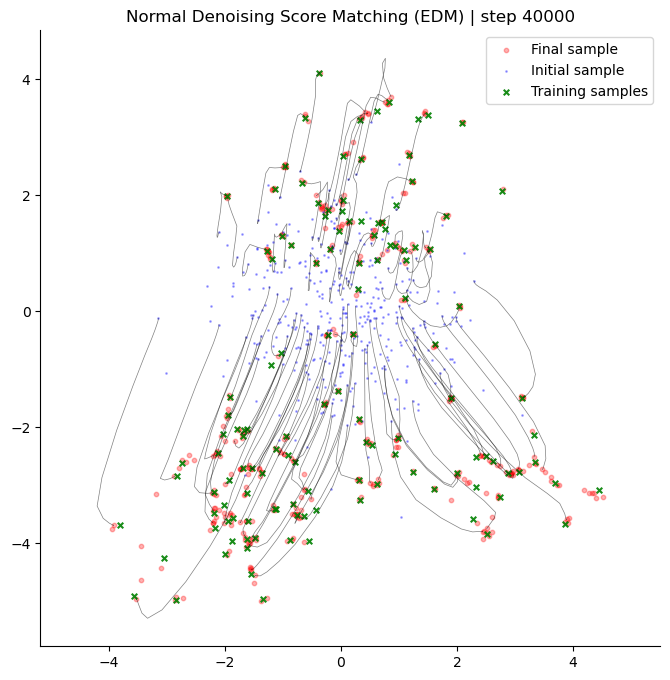

In [73]:
def visualize_trajs(x_traj, t_steps, pnts, title): # x0hat_traj, samples, 
    scaling = 1 / (t_steps ** 2 + 1).sqrt()
    scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
    plt.figure(figsize=[8, 8])
    plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
            scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
    plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=10, marker='o', alpha=0.3, label="Final sample")
    plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=1, marker='o', alpha=0.3, label="Initial sample")
    plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=16, marker='x', alpha=0.9, label="Training samples")
    plt.axis("equal")
    plt.title(title)
    plt.legend()
    return plt.gcf()

train_step = 40000
samples_esm, x_traj_esm, x0hat_traj_esm, t_steps_esm = sample_store_esm[train_step]
samples_dsm, x_traj_dsm, x0hat_traj_dsm, t_steps_dsm = sample_store_dsm[train_step]
visualize_trajs(x_traj_esm[:, ::25], t_steps_esm, pnts, f"Explicit Score Matching to Delta GMM | step {train_step}")
visualize_trajs(x_traj_dsm[:, ::25], t_steps_dsm, pnts, f"Normal Denoising Score Matching (EDM) | step {train_step}");

In [75]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import io
from PIL import Image

# Create frames for animation by going through different training steps
train_steps = record_step_list
frames_esm = []
frames_dsm = []

for train_step in train_steps:
    samples_esm, x_traj_esm, x0hat_traj_esm, t_steps_esm = sample_store_esm[train_step]
    samples_dsm, x_traj_dsm, x0hat_traj_dsm, t_steps_dsm = sample_store_dsm[train_step]
    
    # Create ESM frame
    fig_esm = visualize_trajs(x_traj_esm[:, ::25], t_steps_esm, pnts, f"Explicit Score Matching to Delta GMM | step {train_step}")
    buf = io.BytesIO()
    fig_esm.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    frames_esm.append(Image.open(buf))
    plt.close(fig_esm)
    
    # Create DSM frame
    fig_dsm = visualize_trajs(x_traj_dsm[:, ::25], t_steps_dsm, pnts, f"Normal Denoising Score Matching (EDM) | step {train_step}")
    buf = io.BytesIO()
    fig_dsm.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    frames_dsm.append(Image.open(buf))
    plt.close(fig_dsm)

# Save as GIFs
frames_esm[0].save(join(savedir, "esm_training_progress.gif"), 
                   save_all=True, append_images=frames_esm[1:], 
                   duration=800, loop=0)
frames_esm[0].save(join("/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/DSM_vs_ESM_figs", "esm_training_progress.gif"), 
                   save_all=True, append_images=frames_esm[1:], 
                   duration=800, loop=0)
frames_dsm[0].save(join(savedir, "dsm_training_progress.gif"), 
                   save_all=True, append_images=frames_dsm[1:], 
                   duration=800, loop=0)
frames_dsm[0].save(join("/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/DSM_vs_ESM_figs", "dsm_training_progress.gif"), 
                   save_all=True, append_images=frames_dsm[1:], 
                   duration=800, loop=0)


print(f"Saved ESM training progress GIF to {join(savedir, 'esm_training_progress.gif')}")
print(f"Saved DSM training progress GIF to {join(savedir, 'dsm_training_progress.gif')}")

Saved ESM training progress GIF to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/DSM_vs_Delta_ESM_loss_cmp_GMM_data/esm_training_progress.gif
Saved DSM training progress GIF to /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/DSM_vs_Delta_ESM_loss_cmp_GMM_data/dsm_training_progress.gif


In [65]:
x_traj_esm.shape

torch.Size([21, 10000, 2])

### Evaluation

In [76]:
samples_esm, _, _, _ = sample_store_esm[train_step]
samples_dsm, _, _, _ = sample_store_dsm[train_step]
for train_step in record_step_list:
    samples_esm, _, _, _ = sample_store_esm[train_step]
    samples_dsm, _, _, _ = sample_store_dsm[train_step]
    # Measure distance to closest training datapoint
    # Compute pairwise distances between samples and training data
    dists = torch.cdist(samples_esm, pnts)  # [n_samples, n_train]
    min_dists_esm = dists.min(dim=1)[0]  # Distance to closest training point for each sample
    
    dists = torch.cdist(samples_dsm, pnts)  # [n_samples, n_train]
    min_dists_dsm = dists.min(dim=1)[0]  # Distance to closest training point for each sample
    
    print(f"Step {train_step}:")
    print(f"ESM - Min distance stats: mean={min_dists_esm.mean():.4f}, std={min_dists_esm.std():.4f}, min={min_dists_esm.min():.4f}, max={min_dists_esm.max():.4f}")
    print(f"DSM - Min distance stats: mean={min_dists_dsm.mean():.4f}, std={min_dists_dsm.std():.4f}, min={min_dists_dsm.min():.4f}, max={min_dists_dsm.max():.4f}")
    print()
    
    # # samples_dsm, _, _, _ = sample_store_dsm[train_step]
    # plt.figure(figsize=[8, 8])
    # plt.scatter(samples_esm[:, 0], samples_esm[:, 1], c="red", s=10, marker='o', alpha=0.3, label="ESM")
    # plt.scatter(samples_dsm[:, 0], samples_dsm[:, 1], c="blue", s=10, marker='o', alpha=0.3, label="DSM")
    # plt.legend()
    # plt.show()

Step 500:
ESM - Min distance stats: mean=0.2231, std=0.1335, min=0.0000, max=1.0789
DSM - Min distance stats: mean=0.2866, std=0.1882, min=0.0014, max=1.7600

Step 1000:
ESM - Min distance stats: mean=0.2116, std=0.1273, min=0.0000, max=0.9307
DSM - Min distance stats: mean=0.2787, std=0.1821, min=0.0034, max=1.8081

Step 2000:
ESM - Min distance stats: mean=0.1893, std=0.1156, min=0.0017, max=0.8852
DSM - Min distance stats: mean=0.2632, std=0.1715, min=0.0031, max=1.5501

Step 3000:
ESM - Min distance stats: mean=0.1777, std=0.1080, min=0.0017, max=0.8674
DSM - Min distance stats: mean=0.2534, std=0.1657, min=0.0041, max=1.6239

Step 4000:
ESM - Min distance stats: mean=0.1617, std=0.0986, min=0.0010, max=0.8612
DSM - Min distance stats: mean=0.2374, std=0.1511, min=0.0028, max=1.2859

Step 5000:
ESM - Min distance stats: mean=0.1482, std=0.0934, min=0.0014, max=0.8454
DSM - Min distance stats: mean=0.2251, std=0.1457, min=0.0040, max=1.3423

Step 6000:
ESM - Min distance stats: mean

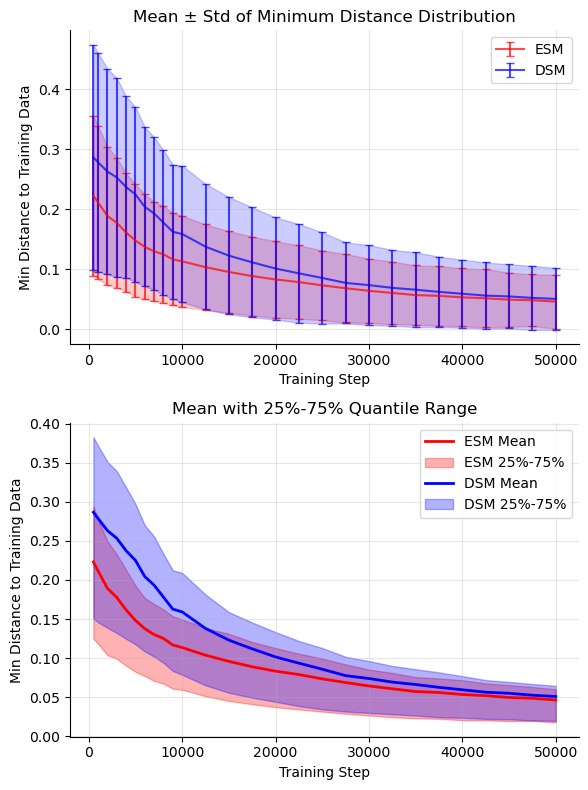

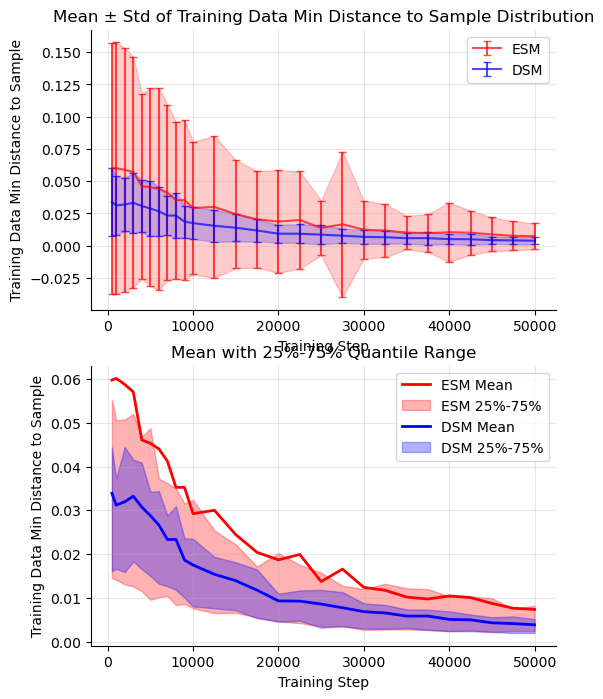

In [80]:
# Collect min distance statistics across all training steps
min_dists_esm_stats = []
min_dists_dsm_stats = []

min_dists_2sample_esm_stats = []
min_dists_2sample_dsm_stats = []
for train_step in record_step_list:
    samples_esm, _, _, _ = sample_store_esm[train_step]
    samples_dsm, _, _, _ = sample_store_dsm[train_step]
    
    # Measure distance to closest training datapoint
    # Compute pairwise distances between samples and training data
    dists = torch.cdist(samples_esm, pnts)  # [n_samples, n_train]
    min_dists_esm = dists.min(dim=1)[0]  # Distance to closest training point for each sample
    min_dists_2sample_esm = dists.min(dim=0)[0]  # Distance to closest sample for each training point
    
    dists = torch.cdist(samples_dsm, pnts)  # [n_samples, n_train]
    min_dists_dsm = dists.min(dim=1)[0]  # Distance to closest training point for each sample
    min_dists_2sample_dsm = dists.min(dim=0)[0]  # Distance to closest sample for each training point
    
    # Store statistics including quantiles
    min_dists_esm_stats.append({
        'mean': min_dists_esm.mean().item(),
        'std': min_dists_esm.std().item(),
        'min': min_dists_esm.min().item(),
        'max': min_dists_esm.max().item(),
        'q25': torch.quantile(min_dists_esm, 0.25).item(),
        'q75': torch.quantile(min_dists_esm, 0.75).item()
    })
    
    min_dists_dsm_stats.append({
        'mean': min_dists_dsm.mean().item(),
        'std': min_dists_dsm.std().item(),
        'min': min_dists_dsm.min().item(),
        'max': min_dists_dsm.max().item(),
        'q25': torch.quantile(min_dists_dsm, 0.25).item(),
        'q75': torch.quantile(min_dists_dsm, 0.75).item()
    })
    
    min_dists_2sample_esm_stats.append({
        'mean': min_dists_2sample_esm.mean().item(),
        'std': min_dists_2sample_esm.std().item(),
        'min': min_dists_2sample_esm.min().item(),
        'max': min_dists_2sample_esm.max().item(),
        'q25': torch.quantile(min_dists_2sample_esm, 0.25).item(),
        'q75': torch.quantile(min_dists_2sample_esm, 0.75).item()
    })
    
    min_dists_2sample_dsm_stats.append({
        'mean': min_dists_2sample_dsm.mean().item(),
        'std': min_dists_2sample_dsm.std().item(),
        'min': min_dists_2sample_dsm.min().item(),
        'max': min_dists_2sample_dsm.max().item(),
        'q25': torch.quantile(min_dists_2sample_dsm, 0.25).item(),
        'q75': torch.quantile(min_dists_2sample_dsm, 0.75).item()
    })

# Extract means, stds, and quantiles for plotting
esm_means = [stats['mean'] for stats in min_dists_esm_stats]
esm_stds = [stats['std'] for stats in min_dists_esm_stats]
esm_q25 = [stats['q25'] for stats in min_dists_esm_stats]
esm_q75 = [stats['q75'] for stats in min_dists_esm_stats]

dsm_means = [stats['mean'] for stats in min_dists_dsm_stats]
dsm_stds = [stats['std'] for stats in min_dists_dsm_stats]
dsm_q25 = [stats['q25'] for stats in min_dists_dsm_stats]
dsm_q75 = [stats['q75'] for stats in min_dists_dsm_stats]

esm_2sample_means = [stats['mean'] for stats in min_dists_2sample_esm_stats]
esm_2sample_stds = [stats['std'] for stats in min_dists_2sample_esm_stats]
esm_2sample_q25 = [stats['q25'] for stats in min_dists_2sample_esm_stats]
esm_2sample_q75 = [stats['q75'] for stats in min_dists_2sample_esm_stats]

dsm_2sample_means = [stats['mean'] for stats in min_dists_2sample_dsm_stats]
dsm_2sample_stds = [stats['std'] for stats in min_dists_2sample_dsm_stats]
dsm_2sample_q25 = [stats['q25'] for stats in min_dists_2sample_dsm_stats]
dsm_2sample_q75 = [stats['q75'] for stats in min_dists_2sample_dsm_stats]

# Plot shaded errorbar curves
plt.figure(figsize=(6, 8))

# Plot with standard deviation
plt.subplot(2, 1, 1)
plt.errorbar(record_step_list, esm_means, yerr=esm_stds, 
             label='ESM', color='red', alpha=0.7, capsize=3)
plt.fill_between(record_step_list, 
                 [m - s for m, s in zip(esm_means, esm_stds)],
                 [m + s for m, s in zip(esm_means, esm_stds)],
                 alpha=0.2, color='red')

plt.errorbar(record_step_list, dsm_means, yerr=dsm_stds,
             label='DSM', color='blue', alpha=0.7, capsize=3)
plt.fill_between(record_step_list,
                 [m - s for m, s in zip(dsm_means, dsm_stds)],
                 [m + s for m, s in zip(dsm_means, dsm_stds)],
                 alpha=0.2, color='blue')

plt.xlabel('Training Step')
plt.ylabel('Min Distance to Training Data')
plt.title('Mean ± Std of Minimum Distance Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot with quantiles
plt.subplot(2, 1, 2)
plt.plot(record_step_list, esm_means, label='ESM Mean', color='red', linewidth=2)
plt.fill_between(record_step_list, esm_q25, esm_q75, alpha=0.3, color='red', label='ESM 25%-75%')

plt.plot(record_step_list, dsm_means, label='DSM Mean', color='blue', linewidth=2)
plt.fill_between(record_step_list, dsm_q25, dsm_q75, alpha=0.3, color='blue', label='DSM 25%-75%')

plt.xlabel('Training Step')
plt.ylabel('Min Distance to Training Data')
plt.title('Mean with 25%-75% Quantile Range')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 2-sample min distance statistics
plt.figure(figsize=(6, 8))
plt.subplot(2, 1, 1)
plt.errorbar(record_step_list, esm_2sample_means, yerr=esm_2sample_stds, 
             label='ESM', color='red', alpha=0.7, capsize=3)
plt.fill_between(record_step_list, 
                 [m - s for m, s in zip(esm_2sample_means, esm_2sample_stds)],
                 [m + s for m, s in zip(esm_2sample_means, esm_2sample_stds)],
                 alpha=0.2, color='red')
                 
plt.errorbar(record_step_list, dsm_2sample_means, yerr=dsm_2sample_stds,
             label='DSM', color='blue', alpha=0.7, capsize=3)
plt.fill_between(record_step_list,
                 [m - s for m, s in zip(dsm_2sample_means, dsm_2sample_stds)],
                 [m + s for m, s in zip(dsm_2sample_means, dsm_2sample_stds)],
                 alpha=0.2, color='blue')
                 
plt.xlabel('Training Step')
plt.ylabel('Training Data Min Distance to Sample')
plt.title('Mean ± Std of Training Data Min Distance to Sample Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(record_step_list, esm_2sample_means, label='ESM Mean', color='red', linewidth=2)
plt.fill_between(record_step_list, esm_2sample_q25, esm_2sample_q75, alpha=0.3, color='red', label='ESM 25%-75%')

plt.plot(record_step_list, dsm_2sample_means, label='DSM Mean', color='blue', linewidth=2)
plt.fill_between(record_step_list, dsm_2sample_q25, dsm_2sample_q75, alpha=0.3, color='blue', label='DSM 25%-75%')

plt.xlabel('Training Step')
plt.ylabel('Training Data Min Distance to Sample')
plt.title('Mean with 25%-75% Quantile Range')
plt.legend()
plt.grid(True, alpha=0.3)




# # Print final statistics
# for i, train_step in enumerate(record_step_list):
#     print(f"Step {train_step}:")
#     print(f"ESM - Min distance stats: mean={esm_means[i]:.4f}, std={esm_stds[i]:.4f}, q25={esm_q25[i]:.4f}, q75={esm_q75[i]:.4f}")
#     print(f"DSM - Min distance stats: mean={dsm_means[i]:.4f}, std={dsm_stds[i]:.4f}, q25={dsm_q25[i]:.4f}, q75={dsm_q75[i]:.4f}")
#     print()

### Better run with sigma data

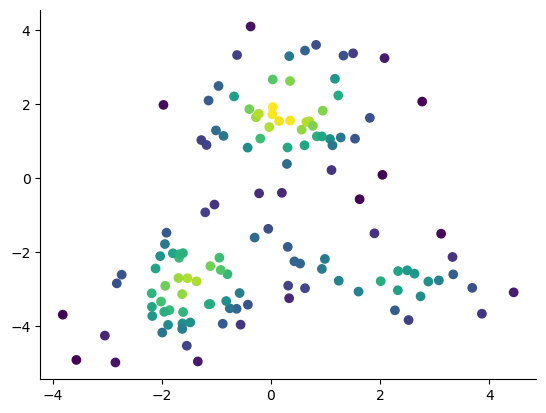

In [12]:
mus = [torch.tensor([-1.5, -2.8]), torch.tensor([2.1, -2.7]), torch.tensor([0.3, 1.9])]
covs = [torch.tensor([[0.8, 0.3], [0.3, 1.2]]), 
        torch.tensor([[1.5, -0.4], [-0.4, 0.6]]), 
        torch.tensor([[0.9, 0.1], [0.1, 1.1]])]
weights = [1.2, 0.8, 1.5]
gmm = GaussianMixture_torch(mus, covs, weights)
torch.manual_seed(42)
pnts, _, _ = gmm.sample(128)
density = gmm.pdf(pnts)
plt.scatter(pnts[:, 0], pnts[:, 1], c=density, cmap="viridis")
plt.show()

In [14]:
sigma_data = pnts.std().item()

In [16]:
savedir = join(saveroot, "DSM_vs_Delta_ESM_loss_cmp_GMM_data_wellnormed")
os.makedirs(savedir, exist_ok=True)

In [17]:
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model, manual_seed=0):
    loss_store[epoch] = loss
    noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

record_step_list = [*range(0, 50000, 1000)]#[500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 32500, 35000, 37500, 40000, 42500, 45000, 47500, 50000]
device = get_device()
ndim = pnts.shape[1]
cov_empirical = torch.cov(pnts.T, correction=1)
print(f"MNIST dataset {pnts.shape[0]} samples, {ndim} features")
model_esm = UNetBlockStyleMLP_backbone(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_esm = EDMPrecondWrapper(model_esm, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
# edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
edm_delta_gmm_loss_fn = EDMDeltaGMMScoreLoss(train_Xmat=pnts.to(device), P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd_esm, loss_traj_esm = train_score_model_custom_loss(pnts, model_precd_esm, edm_delta_gmm_loss_fn, 
                                    lr=0.0001, nepochs=50000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)
torch.save({"pnts": pnts, "mus": mus, "covs": covs, "weights": weights}, join(savedir, "training_data.pth"))
torch.save(loss_traj_esm, join(savedir, "loss_traj_esm.pth"))
torch.save(sample_store, join(savedir, "sample_store_esm.pth"))
torch.save(model_precd_esm, join(savedir, "model_precd_esm.pth"))

sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model, manual_seed=0):
    loss_store[epoch] = loss
    noise_init = torch.randn(2000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

model_esm2 = UNetBlockStyleMLP_backbone(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_esm2 = EDMPrecondWrapper(model_esm2, sigma_data=sigma_data, sigma_min=0.002, sigma_max=80, rho=7.0)
# edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
edm_delta_gmm_loss_fn = EDMDeltaGMMScoreLoss(train_Xmat=pnts.to(device), P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd_esm2, loss_traj_esm2 = train_score_model_custom_loss(pnts, model_precd_esm2, edm_delta_gmm_loss_fn, 
                                    lr=0.0001, nepochs=50000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)
torch.save(loss_traj_esm2, join(savedir, "loss_traj_esm_2.pth"))
torch.save(sample_store, join(savedir, "sample_store_esm_2.pth"))
torch.save(model_precd_esm2, join(savedir, "model_precd_esm_2.pth"))



sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model, manual_seed=0):
    loss_store[epoch] = loss
    noise_init = torch.randn(10000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()
    
model_dsm = UNetBlockStyleMLP_backbone(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_dsm = EDMPrecondWrapper(model_dsm, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
model_precd_dsm, loss_traj_dsm = train_score_model_custom_loss(pnts, model_precd_dsm, edm_loss_fn, 
                                    lr=0.0001, nepochs=50000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

torch.save(loss_traj_dsm, join(savedir, "loss_traj_dsm.pth"))
torch.save(sample_store, join(savedir, "sample_store_dsm.pth"))
torch.save(model_precd_dsm, join(savedir, "model_precd_dsm.pth"))



sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model, manual_seed=0):
    loss_store[epoch] = loss
    noise_init = torch.randn(10000, ndim, generator=torch.Generator(device=device).manual_seed(manual_seed), device=device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()
    
model_dsm2 = UNetBlockStyleMLP_backbone(ndim=ndim, nlayers=5, nhidden=128, time_embed_dim=64,)
model_precd_dsm2 = EDMPrecondWrapper(model_dsm2, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=sigma_data)
model_precd_dsm2, loss_traj_dsm2 = train_score_model_custom_loss(pnts, model_precd_dsm2, edm_loss_fn, 
                                    lr=0.0001, nepochs=50000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

torch.save(loss_traj_dsm2, join(savedir, "loss_traj_dsm_2.pth"))
torch.save(sample_store, join(savedir, "sample_store_dsm_2.pth"))
torch.save(model_precd_dsm2, join(savedir, "model_precd_dsm_2.pth"))

# noise_init = torch.randn(1000, ndim).to(device)
# x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
#                 num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

# scaling = 1 / (t_steps ** 2 + 1).sqrt()
# scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
# plt.figure(figsize=[8, 8])
# plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
#         scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
# plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=4, marker='o', alpha=0.3, label="Final sample")
# plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=9, marker='o', alpha=0.3, label="Initial sample")
# plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=4, marker='o', alpha=0.2, label="Training samples")
# plt.axis("equal")
# plt.legend()
# plt.show() 

MNIST dataset 128 samples, 2 features


  0%|          | 0/50000 [00:00<?, ?it/s]

step 0 loss 4.124


  0%|          | 0/50000 [00:00<?, ?it/s]

step 0 loss 4.414


  0%|          | 0/50000 [00:00<?, ?it/s]

step 0 loss 4.020


  0%|          | 0/50000 [00:00<?, ?it/s]

step 0 loss 4.422


### Try to check the score consistency between models 

/n/home12/binxuwang/Github/DiffusionLearningCurve/core/diffusion_edm_lib.py:37: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1728241823685/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:716.)
  sigma[sigma == 0] = self.sigma_min
/n/home12/binxuwang/Github/DiffusionLearningCurve/core/diffusion_edm_lib.py:37: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1728241823685/work/aten/src/ATen/native/cuda/Indexing.cu:1561.)
  sigma[sigma == 0] = self.sigma_min


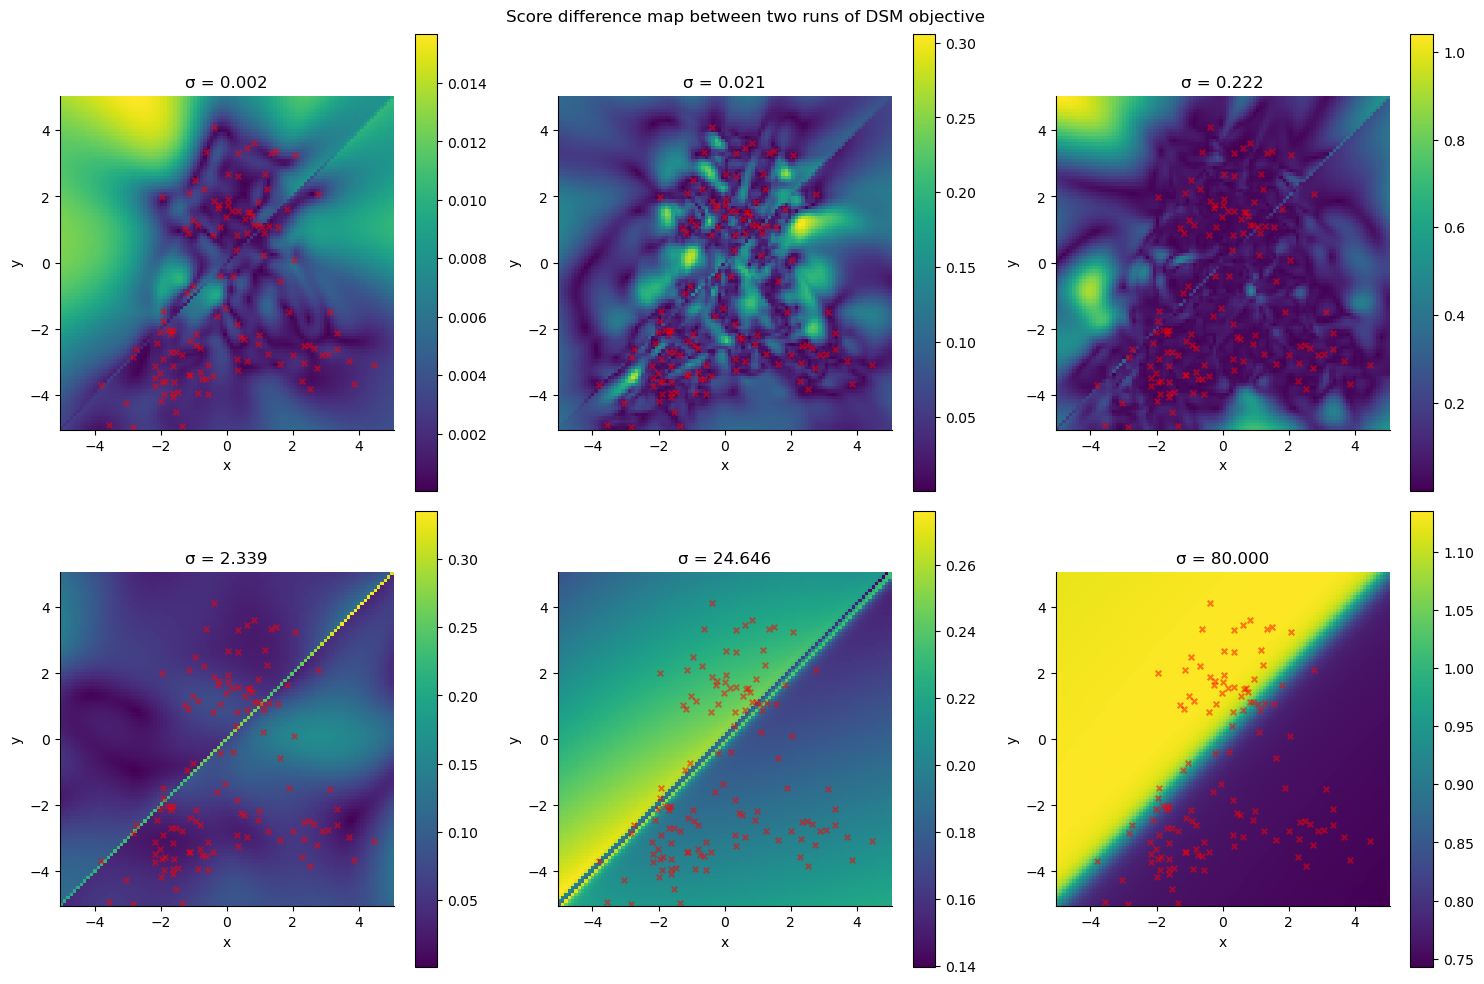

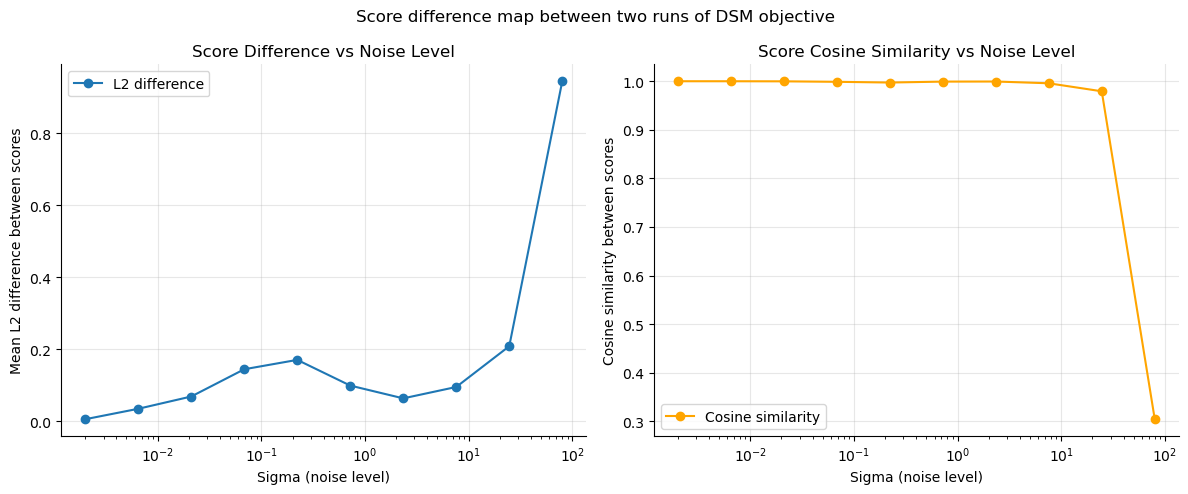

Average cosine similarity across noise levels: 0.9274
Average L2 difference across noise levels: 0.1834


In [24]:
# Create a grid of test points to compare score similarity between models
test_grid_size = 100
x_range = torch.linspace(-5, 5, test_grid_size)
y_range = torch.linspace(-5, 5, test_grid_size)
xx, yy = torch.meshgrid(x_range, y_range, indexing='ij')
test_grid = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

# Generate random time points for score evaluation
n_time_points = 10
sigma_values = torch.logspace(torch.log10(torch.tensor(0.002)), torch.log10(torch.tensor(80.0)), n_time_points).to(device)

# Evaluate scores for both models at different noise levels
score_similarities = []
cosine_similarities = []
score_vec_diff_map = []
model_precd_dsm.eval()
model_precd_dsm2.eval()

with torch.no_grad():
    for sigma in sigma_values:
        # Get scores from both models
        score1 = model_precd_dsm(test_grid, sigma.expand(test_grid.shape[0]))
        score2 = model_precd_dsm2(test_grid, sigma.expand(test_grid.shape[0]))
        
        # Calculate cosine similarity
        score1_flat = score1.view(-1)
        score2_flat = score2.view(-1)
        cosine_sim = torch.nn.functional.cosine_similarity(score1_flat.unsqueeze(0), score2_flat.unsqueeze(0))
        cosine_similarities.append(cosine_sim.item())
        # collect the score difference as a spatial map
        score_diff = score1 - score2
        score_vec_diff_map.append(score_diff)
        
        # Calculate L2 difference
        l2_diff = torch.norm(score1 - score2, dim=1).mean()
        score_similarities.append(l2_diff.item())


# plot the score difference map
score_vec_diff_map = torch.stack(score_vec_diff_map, dim=0)
score_diff_map = score_vec_diff_map.norm(dim=-1)
score_diff_map = score_diff_map.view(-1, test_grid_size, test_grid_size)
# Plot score difference maps at different noise levels with training points overlaid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Select a few different noise levels to show
noise_indices = [0, 2, 4, 6, 8, -1]  # Show maps at different sigma values

for i, idx in enumerate(noise_indices):
    ax = axes[i]
    # Plot the score difference map
    im = ax.pcolormesh(xx.cpu(), yy.cpu(), score_diff_map[idx,:,:].cpu(), cmap='viridis')
    # Overlay training points
    ax.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), 
               c='red', s=16, alpha=0.5, label='Training points', marker='x')
    ax.set_title(f'σ = {sigma_values[idx]:.3f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    # Add colorbar for each subplot
    plt.colorbar(im, ax=ax)

plt.suptitle("Score difference map between two runs of DSM objective")
plt.tight_layout()
plt.show()


# Plot score similarity analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(sigma_values.cpu().numpy(), score_similarities, 'o-', label='L2 difference')
ax1.set_xlabel('Sigma (noise level)')
ax1.set_ylabel('Mean L2 difference between scores')
ax1.set_xscale('log')
ax1.set_title('Score Difference vs Noise Level')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(sigma_values.cpu().numpy(), cosine_similarities, 'o-', color='orange', label='Cosine similarity')
ax2.set_xlabel('Sigma (noise level)')
ax2.set_ylabel('Cosine similarity between scores')
ax2.set_xscale('log')
ax2.set_title('Score Cosine Similarity vs Noise Level')
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.suptitle("Score difference map between two runs of DSM objective")

plt.tight_layout()
plt.show()

print(f"Average cosine similarity across noise levels: {np.mean(cosine_similarities):.4f}")
print(f"Average L2 difference across noise levels: {np.mean(score_similarities):.4f}")


/n/home12/binxuwang/Github/DiffusionLearningCurve/core/diffusion_edm_lib.py:37: UserWarning: Use of index_put_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[indices] = tensor (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1728241823685/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:716.)
  sigma[sigma == 0] = self.sigma_min
/n/home12/binxuwang/Github/DiffusionLearningCurve/core/diffusion_edm_lib.py:37: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1728241823685/work/aten/src/ATen/native/cuda/Indexing.cu:1561.)
  sigma[sigma == 0] = self.sigma_min


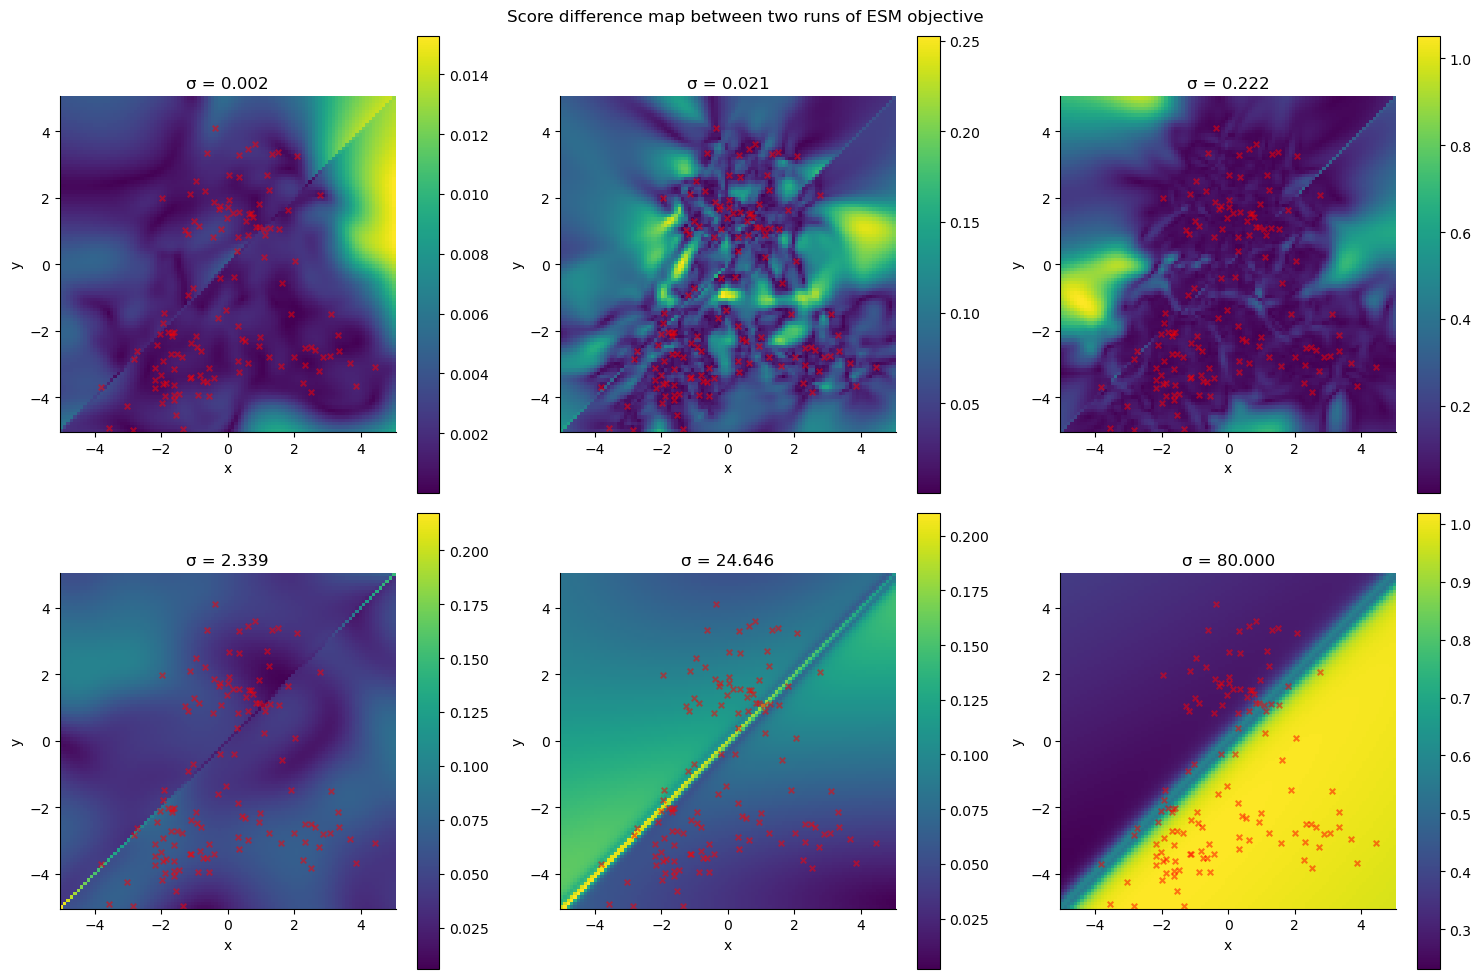

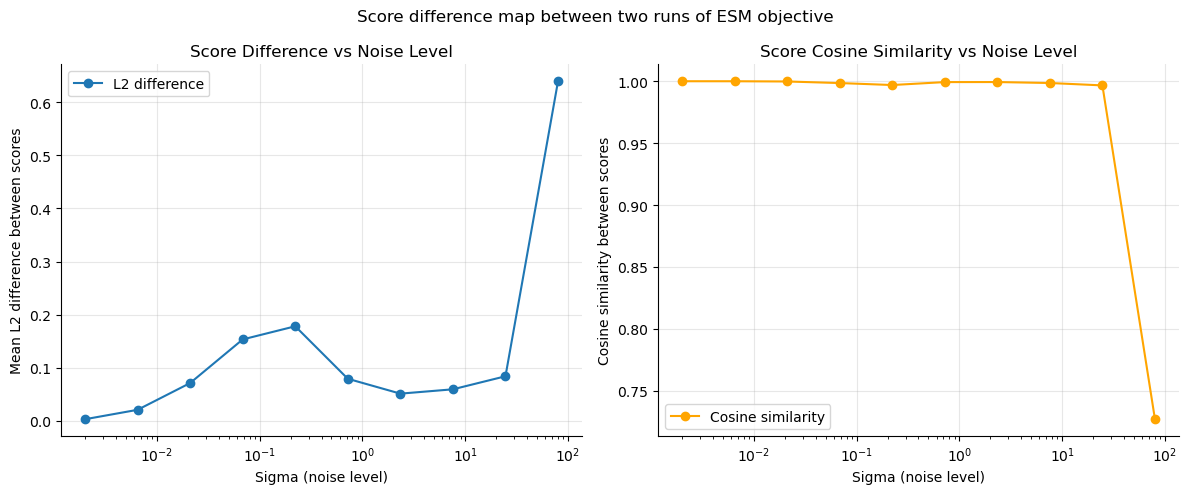

Average cosine similarity across noise levels: 0.9716
Average L2 difference across noise levels: 0.1340


In [ ]:
# Create a grid of test points to compare score similarity between models
test_grid_size = 100
x_range = torch.linspace(-5, 5, test_grid_size)
y_range = torch.linspace(-5, 5, test_grid_size)
xx, yy = torch.meshgrid(x_range, y_range, indexing='ij')
test_grid = torch.stack([xx.flatten(), yy.flatten()], dim=1).to(device)

# Generate random time points for score evaluation
n_time_points = 10
sigma_values = torch.logspace(torch.log10(torch.tensor(0.002)), torch.log10(torch.tensor(80.0)), n_time_points).to(device)

# Evaluate scores for both models at different noise levels
score_similarities = []
cosine_similarities = []
score_vec_diff_map = []
cosine_similarities_at_each_point_col = []
model_precd_esm.eval()
model_precd_esm2.eval()

with torch.no_grad():
    for sigma in sigma_values:
        # Get scores from both models
        score1 = model_precd_esm(test_grid, sigma.expand(test_grid.shape[0]))
        score2 = model_precd_esm2(test_grid, sigma.expand(test_grid.shape[0]))
        
        # Calculate cosine similarity
        score1_flat = score1.view(-1)
        score2_flat = score2.view(-1)
        cosine_sim = torch.nn.functional.cosine_similarity(score1_flat.unsqueeze(0), score2_flat.unsqueeze(0))
        cosine_similarities.append(cosine_sim.item())
        # cosine similarity at each point
        cosine_similarities_at_each_point = torch.nn.functional.cosine_similarity(score1, score2, dim=1)
        cosine_similarities_at_each_point_col.append(cosine_similarities_at_each_point)
        # collect the score difference as a spatial map
        score_diff = score1 - score2
        score_vec_diff_map.append(score_diff)
        
        # Calculate L2 difference
        l2_diff = torch.norm(score1 - score2, dim=1).mean()
        score_similarities.append(l2_diff.item())


# plot the score difference map
score_vec_diff_map = torch.stack(score_vec_diff_map, dim=0)
score_diff_map = score_vec_diff_map.norm(dim=-1)
score_diff_map = score_diff_map.view(-1, test_grid_size, test_grid_size)
# Plot score difference maps at different noise levels with training points overlaid
fig, axes = plt.subplots(2, 5, figsize=(17, 7))
axes = axes.flatten()
# Select a few different noise levels to show
for i, idx in enumerate(range(len(sigma_values))):
    ax = axes[i]
    # Plot the score difference map
    im = ax.pcolormesh(xx.cpu(), yy.cpu(), score_diff_map[idx,:,:].cpu(), cmap='viridis')
    # Overlay training points
    ax.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), 
               c='red', s=16, alpha=0.5, label='Training points', marker='x')
    ax.set_title(f'σ = {sigma_values[idx]:.3f}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_aspect('equal')
    # Add colorbar for each subplot
    plt.colorbar(im, ax=ax)

plt.suptitle("Score difference map between two runs of ESM objective")
plt.tight_layout()
plt.show()


# Plot score similarity analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(sigma_values.cpu().numpy(), score_similarities, 'o-', label='L2 difference')
ax1.set_xlabel('Sigma (noise level)')
ax1.set_ylabel('Mean L2 difference between scores')
ax1.set_xscale('log')
ax1.set_title('Score Difference vs Noise Level')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(sigma_values.cpu().numpy(), cosine_similarities, 'o-', color='orange', label='Cosine similarity')
ax2.set_xlabel('Sigma (noise level)')
ax2.set_ylabel('Cosine similarity between scores')
ax2.set_xscale('log')
ax2.set_title('Score Cosine Similarity vs Noise Level')
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.suptitle("Score difference map between two runs of ESM objective")

plt.tight_layout()
plt.show()

print(f"Average cosine similarity across noise levels: {np.mean(cosine_similarities):.4f}")
print(f"Average L2 difference across noise levels: {np.mean(score_similarities):.4f}")


### MNIST

In [ ]:
!echo $STORE_DIR/Datasets

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets


In [ ]:
import torchvision
import torchvision.transforms as transforms
# load MNIST dataset, make it a B x 28 x 28 tensor
mnist_dataset = torchvision.datasets.MNIST(root='/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Data', 
                                           train=True, download=True, transform=transforms.ToTensor())
mnist_Xtsr = torch.stack([mnist_dataset[i][0] for i in range(len(mnist_dataset))])
print(mnist_Xtsr.shape) # 60000 x 28 x 28

torch.Size([60000, 1, 28, 28])


In [ ]:
savedir = f"{saveroot}/MNIST_MLP_EDM_width1024_small_lr_long_train"
os.makedirs(savedir, exist_ok=True)

device = get_device()
pnts = mnist_Xtsr.view(mnist_Xtsr.shape[0], -1).to(device)
pnts = (pnts - 0.5) / 0.5
ndim = pnts.shape[1]
X_mean = pnts.mean(dim=0)
cov_empirical = torch.cov(pnts.T, correction=1)
# diagonalize the covariance matrix
cov_empirical_eigs, cov_empirical_evecs = torch.linalg.eigh(cov_empirical)
cov_empirical_eigs = cov_empirical_eigs.flip(0)
cov_empirical_evecs = cov_empirical_evecs.flip(1)
rot = cov_empirical_evecs
diag_var = cov_empirical_eigs
assert torch.allclose(rot @ torch.diag(diag_var) @ rot.T, cov_empirical, atol=5e-5)
pkl.dump({"diag_var": diag_var.cpu(), 
          "rot": rot.cpu(), 
          #   "cov": cov.cpu(), 
          "cov_empirical": cov_empirical.cpu(),
          "X_mean": X_mean.cpu(),
          "train_pnts": pnts.cpu()}, open(f"{savedir}/train_data_cov_info.pkl", "wb"))

In [ ]:
record_step_list = [*range(0, 10, 1), *range(10, 50, 2), *range(50, 100, 4), *range(100, 500, 8), *range(500, 2500, 16), 
                    *range(2500, 5000, 32), *range(5000, 10000, 64), *range(10000, 20000, 128), *range(20000, 50000, 256), *range(50000, 100000, 512)]

MNIST dataset 60000 samples, 784 features


  0%|          | 0/100000 [00:00<?, ?it/s]

step 0 loss 2.743


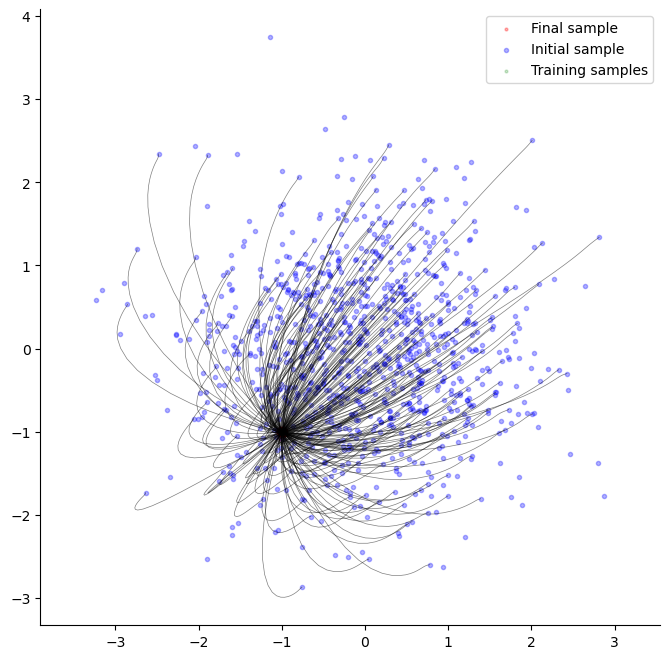

In [ ]:
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model):
    loss_store[epoch] = loss
    noise_init = torch.randn(10000, ndim).to(device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), # x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

device = get_device()
pnts = mnist_Xtsr.view(mnist_Xtsr.shape[0], -1).to(device)
pnts = (pnts - 0.5) / 0.5
ndim = pnts.shape[1]
cov_empirical = torch.cov(pnts.T, correction=1)
print(f"MNIST dataset {pnts.shape[0]} samples, {ndim} features")
model = UNetBlockStyleMLP_backbone(ndim=ndim, nlayers=8, nhidden=1024, time_embed_dim=128,)
model_precd = EDMPrecondWrapper(model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(pnts, model_precd, edm_loss_fn, 
                                    lr=0.0001, nepochs=100000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=0, 
                                    callback_step_list=record_step_list)

noise_init = torch.randn(1000, ndim).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8, 8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=4, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=9, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=4, marker='o', alpha=0.2, label="Training samples")
plt.axis("equal")
plt.legend()
plt.show()